In [3]:
!pip install --no-cache-dir torch torchvision torchaudio -q
!pip install --no-cache-dir pytorch-lightning -q
!pip install --no-cache-dir custatevec-cu12 -q
!pip install --no-cache-dir lightning pennylane-lightning-gpu -q
!pip install --no-cache-dir pandas matplotlib -q
#!pip install "jax[cuda11_pip]==0.4.28" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

## Data Preprocessing

In [5]:
import os
import io
import re
import gzip
import pandas as pd
import pennylane.numpy as np
from glob import glob
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter


def load_weather_data(folder_path='.', datetime_format='%d-%b-%Y %H:%M'):
    """
    Load all .csv weather files (rainfall/wind) in folder_path.        
    """
    datasets = {}
    # Expected headers
    expected_keywords = ['date', 'time', 'rain', 'wind']
    
    for file in glob(os.path.join(folder_path, '*.csv')):
        name = file.strip().replace('.csv','')
        name = re.sub(r'\s+', '', name)
        try:            
            with open(file, 'rt') as f:
                lines = f.readlines()
                            
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().split(" "))                
                if any(keyword in tokens for keyword in expected_keywords):
                    header_idx = idx
                    break                        
            
            # Load csv
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str,
                low_memory=False
            )
            
            # Parse datetime
            if 'date' in df.columns and 'time' in df.columns:
                df['datetime'] = pd.to_datetime(
                    df['date'] + ' ' + df['time'],
                    format=datetime_format,
                    errors='coerce'
                )
                df.drop(columns=['date', 'time'], inplace=True)                
            else:
                # fallback
                dt_col = next((col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()), None) 
                df['datetime'] = pd.to_datetime(df[dt_col], format=datetime_format, errors='coerce')                
                df.drop(columns=[dt_col], inplace=True)
                        
            rename_map = {}
            for c in df.columns:
                lc = c.lower()
                if 'rain' in lc: 
                    rename_map[c] = 'rainfall_mm'
                if 'wind' in lc and 'speed' in lc:
                    rename_map[c] = 'wind_speed_mps'
            df.rename(columns=rename_map, inplace=True)
            df['wind_speed_mps'] = df['wind_speed_mps'].replace({'VRB': None, 'NA': None, 'NaN': None})
                        
            df = df[['datetime', 'rainfall_mm', 'wind_speed_mps']].copy()            
            df = df.dropna(subset=['datetime', 'rainfall_mm', 'wind_speed_mps'])                                
            df['rainfall_mm'] = pd.to_numeric(df['rainfall_mm'], errors='coerce')
            df['wind_speed_mps'] = pd.to_numeric(df['wind_speed_mps'], errors='coerce')
            
            df = df.sort_values('datetime').reset_index(drop=True)
            start_date = pd.Timestamp('2019-10-21')
            df = df[df['datetime'] >= start_date]                
            print(f"Weather loaded: {name} ({len(df)} rows)")
        
        except Exception as e:
            print(f"Skipping {name}: {e}")
    
    return df

def load_river_level_data(folder_path='.', river_sites=None, datetime_format='%Y-%m-%d %H:%M:%S'):
    """
    Load river level csv for specified river_sites.        
    """
    if river_sites is None:
        river_sites = ['waikato', 'waipa', '']
    datasets = {}
    expected_cols = ['date', 'time', 'wlvalue', 'flvalue']
    for file in glob(os.path.join(folder_path, '*.csv')) + glob(os.path.join(folder_path, '*.csv')):
        name = os.path.basename(file)
        
        if not any(site.lower() in name.lower() for site in river_sites):
            continue
        try:            
            opener = gzip.open if file.endswith('.gz') else open
            with opener(file, 'rt') as f:
                lines = f.readlines()
            
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().replace(',',' ').split())                
                if any(keyword in tokens for keyword in expected_cols):
                    header_idx = idx
                    break
                                
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str, low_memory=False
            )            
                    
            if 'date' in df.columns and 'time' in df.columns:                
                df['dt'] = df['date'] + ' ' + df['time']                                
                df['datetime'] = pd.to_datetime(
                    df['dt'],
                    format=datetime_format,
                    errors='coerce'
                )                
                df.drop(columns=['date', 'time', 'dt'], inplace=True)                
                        
            df['river_level'] = df['wlvalue'].astype(float)
            df = df.dropna(subset=['datetime', 'river_level'])            
            df = df[['datetime', 'river_level']].sort_values('datetime')
            df = df.set_index('datetime')
            #resample data hourly
            df = df.resample('h').ffill()  
            print(f"River loaded: {name} ({len(df)} rows)")
            datasets[name] = df
        except Exception as e:
            print(f"Skipping river {name}: {e}")
    return datasets

def merge_weather_and_river(weather_df, river_df):
    """
    Merge weather and river level data on exact datetime match (inner join).    
    """
    # Ensure both are in datetime64[ns] type
    weather_df = weather_df.copy()
    river_df = river_df.copy()    
    
    # Inner join on exact datetime match
    merged = pd.merge(weather_df, river_df, on='datetime', how='inner')

    #print(f"Merged {len(merged)} rows on datetime match")

    return merged

def visualize_merged_data(data, threshold=150, title='Merged Timeseries'):
    """
    Plot rainfall and river level with threshold line.
    """
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(data['datetime'], data['rainfall_mm'], label='Rainfall (mm)', color='blue')
    ax1.set_xlabel('Datetime'); ax1.set_ylabel('Rainfall (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')    
    
    ax2 = ax1.twinx()
    ax2.plot(data['datetime'], data['river_level'], label='River Level (m)', color='green')
    ax2.set_ylabel('River Level (m)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    #fig.tight_layout()
    plt.title(title)
    fig.legend()
    plt.show()

# Load data
weather_data = load_weather_data(folder_path='/kaggle/input/wbcfull/rainfall_data')
river_data = load_river_level_data(folder_path='/kaggle/input/wbcfull/riverlevel_data', river_sites=['waikato','waipa', 'waihou'])
merged_data = {}

# Merge matching datasets
for rname, rdata in river_data.items():
    merged_data[rname] = merge_weather_and_river(weather_data, rdata)

key = next(iter(merged_data))
df_merge = merged_data[key]

Weather loaded: /kaggle/input/wbcfull/rainfall_data/Observations_Hourly_Auckland_Aerodrome_NZAAA_1993Jan01_2025May23 (48875 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv (48960 rows)
River loaded: River Level - Waihou River - Okauia - 1st Jan 1993 - 23rd May 2025.csv (45432 rows)
River loaded: RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv (48960 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv (48960 rows)
River loaded: River Level - Waihou River - Okauia - 1st Jan 1993 - 23rd May 2025.csv (45432 rows)
River loaded: RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv (48960 rows)


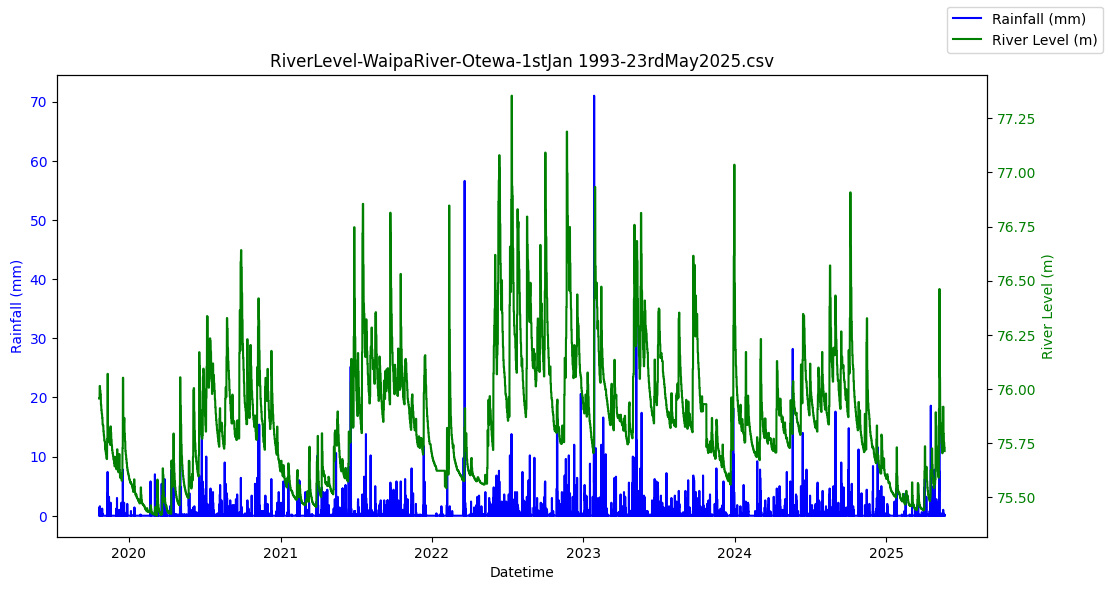

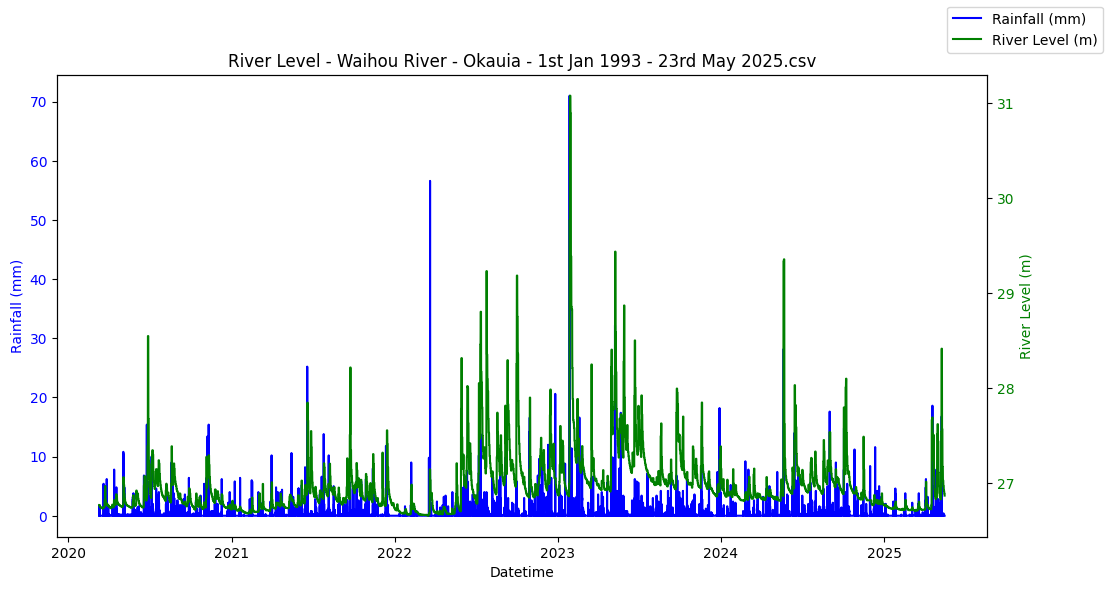

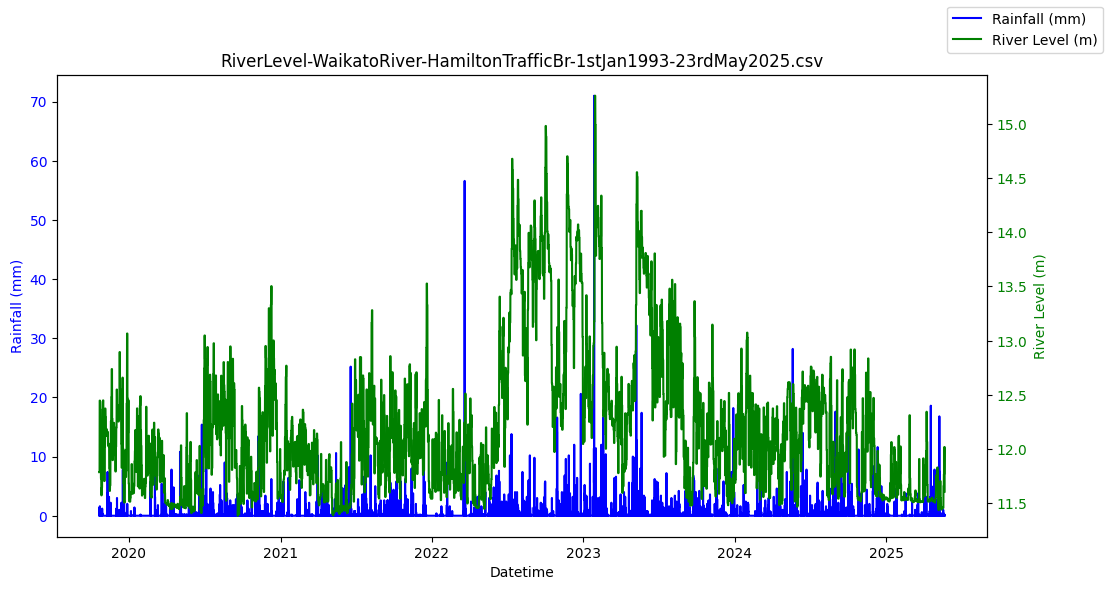

In [6]:
# Visualize
for key, df_merge in merged_data.items():    
    visualize_merged_data(df_merge, title=key)

In [7]:
print(merged_data.keys())
merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv']

dict_keys(['RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv', 'River Level - Waihou River - Okauia - 1st Jan 1993 - 23rd May 2025.csv', 'RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'])


,datetime,rainfall_mm,wind_speed_mps,river_level
0,2019-10-21 01:00:00,0.2,8.8,11.787
1,2019-10-21 02:00:00,0.0,8.8,11.787
2,2019-10-21 03:00:00,0.0,8.8,11.787
3,2019-10-21 04:00:00,0.0,8.8,11.787
4,2019-10-21 05:00:00,0.0,8.8,11.787
...,...,...,...,...
48845,2025-05-21 20:00:00,0.0,0.5,12.019
48846,2025-05-21 21:00:00,0.0,1.0,12.019
48847,2025-05-21 22:00:00,0.0,0.5,12.019
48848,2025-05-21 23:00:00,0.0,0.5,12.019


Data shape: (730, 4)


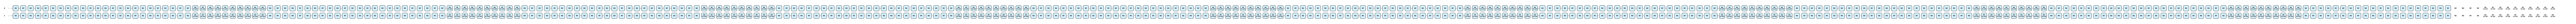

Trainable parameters: 686


Training QRU_Waikato:   1%|          | 2/300 [01:28<2:27:34, 29.71s/it, Loss=0.7194, Acc=4.23%, GradNorm=3.3931, BestEpoch=1] 

In [ ]:
import random
import pandas as pd
import pennylane as qml
import numpy as np
import torch
import matplotlib.pyplot as plt
import csv
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

nb_reuploading = 10
lookback = 24  # window size
feature_col = ['rainfall_mm','wind_speed_mps']
X_features = len(feature_col)
target_col = ['river_level']
y_features = len(target_col)

nb_qubit_reupload = X_features
num_variational = 10
nb_epoch = 300
lr = 0.01
batch_size = 16

dev_reupload = qml.device("default.qubit", wires=nb_qubit_reupload, shots=None)

def generate_windowed_dataset(data, lookback=24, feature_cols=None, target_col='river_level'):
    """
    Create (X, y) with features from lookback hours    
    """
    if feature_cols is None:
        feature_cols = [c for c in ['rainfall_mm','wind_speed_mps'] if c in data.columns]
    X, y = [], []
    for i in range(len(data) - lookback):
        window = data[feature_cols].iloc[i:i+lookback].values
        target = data[target_col].iloc[i + lookback]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

def encoding_layer(params_encoding, x, lookback, nb_qubit):        
    x = x.reshape(-1, lookback, X_features)
    #print("params_encoding.shape, x.shape", params_encoding.shape, x.shape)
    
    rotation_gates = [qml.RX, qml.RY, qml.RZ]
    for q in range(X_features):
        for j in range(lookback):            
            gate = rotation_gates[j % len(rotation_gates)]            
            gate(params_encoding[q,j] * x[:,j,q], wires=q)

def variational_layer(params_variational, lookback, nb_qubit, num_variational):
    #print("params_variational.shape", params_variational.shape)
    rotation_gates = [qml.RX, qml.RY, qml.RZ]
    for q in range(nb_qubit):
        for k in range(num_variational):
            gate = rotation_gates[k % len(rotation_gates)]                        
            gate(params_variational[q, k], wires=q)

@qml.qnode(dev_reupload, interface="torch", diff_method="backprop")
def quantum_circuit_reupload(x, params):
    params_enc, params_var, ent_wieghts = params        
    for i in range(nb_reuploading):
        encoding_layer(params_enc[i], x, lookback, nb_qubit_reupload)
        variational_layer(params_var[i], lookback, nb_qubit_reupload, num_variational)

    qml.StronglyEntanglingLayers(weights=ent_wieghts, wires=range(nb_qubit_reupload))    
    #return  [qml.expval(qml.PauliZ(i)) for i in range(nb_qubit_reupload)]
    return qml.expval(qml.PauliZ(0))

def prediction_accuracy(y_pred, y_true, tolerance=0.1):
    correct = torch.sum(torch.abs(y_pred - y_true) < tolerance)
    return 100 * correct / len(y_true)

def split_data(data, test_ratio, lookback, target_col):
    X, y = generate_windowed_dataset(data, lookback=lookback, target_col=target_col)
    split = int(len(X) * (1 - test_ratio))
    return X[:split], y[:split], X[split:], y[split:]

def plot_metrics(loss_hist, acc_hist, grad_norm_hist, name):
    epochs = range(1, len(loss_hist)+1)
    plt.figure()
    plt.plot(epochs, loss_hist, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name}: Test Loss over Epochs")
    plt.legend()
    plt.savefig(f"{name}_loss_plot.png", dpi=300)
    plt.close()

    plt.figure()
    plt.plot(epochs, acc_hist, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{name}: Test Accuracy over Epochs")
    plt.legend()
    plt.savefig(f"{name}_accuracy_plot.png", dpi=300)
    plt.close()

    plt.figure()
    plt.plot(epochs, grad_norm_hist, label="Gradient Norm")
    plt.xlabel("Epochs")
    plt.ylabel("L2 Norm")
    plt.title(f"{name}: Gradient Norm over Epochs")
    plt.legend()
    plt.savefig(f"{name}_gradnorm_plot.png", dpi=300)
    plt.close()

def plot_predictions(y_true, y_pred, name):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label="Ground Truth", linewidth=2)
    plt.plot(y_pred, label="Predictions", linestyle="--")
    plt.xlabel("Index")
    plt.ylabel("Normalized Value")
    plt.title(f"{name}: Predictions vs Ground Truth")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name}_prediction_plot.png", dpi=300)
    plt.close()

def train_and_eval(model, params_init, X_tr, y_tr, X_te, y_te, name, epochs, lr):
    params = [p.clone().detach().requires_grad_(True) for p in params_init]
    opt = torch.optim.AdamW(params, lr=lr)
    loss_hist, acc_hist, grad_norm_hist = [], [], []
    param_count = sum(p.numel() for p in params if p.requires_grad)
    print(f"Trainable parameters: {param_count}")    
    mse_loss = torch.nn.MSELoss()
    train_ds = TensorDataset(X_tr, y_tr)    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=0)
    

    with open(f"{name}_metrics.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "test_loss", "test_acc", "grad_norm"])

        progress_bar = trange(epochs, desc=f"Training {name}")
        best_loss = float("inf")
        best_epoch = -1

        for ep in progress_bar:        
            for X_batch, y_batch in train_loader:
                #print("X_batch, y_batch shapes", X_batch.shape, y_batch.shape)
                opt.zero_grad()                
                preds = model(X_batch, params)
                #print("preds.shape", preds.shape)
                #preds = torch.stack(preds) if isinstance(preds, list) else preds                
                loss = mse_loss(preds.squeeze(), y_batch.squeeze())
                loss.backward()
                            
                total_norm = 0.0
                for p in params:
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                grad_norm = total_norm ** 0.5
                
                opt.step()

            with torch.no_grad():                   
                preds_t = model(X_te, params)
                loss_t = mse_loss(preds_t.squeeze(), y_te.squeeze()).item()
                acc_t = prediction_accuracy(preds_t, y_te).item()

            loss_hist.append(loss_t)
            acc_hist.append(acc_t)
            grad_norm_hist.append(grad_norm)

            if loss_t < best_loss:
                best_loss = loss_t
                best_epoch = ep + 1

            progress_bar.set_postfix({
                "Loss": f"{loss_t:.4f}",
                "Acc": f"{acc_t:.2f}%",
                "GradNorm": f"{grad_norm:.4f}",
                "BestEpoch": best_epoch
            })

            writer.writerow([ep+1, loss_t, acc_t, grad_norm])
            f.flush()

    plot_metrics(loss_hist, acc_hist, grad_norm_hist, name)
    torch.save([p.detach() for p in params], f"{name}_trained_params.pt")

    with torch.no_grad():
        #preds_final = torch.stack([model(params, x) for x in X_te])
        preds_final = model(X_te, params)
        with open(f"{name}_predictions.csv", "w", newline="") as f_pred:
            writer = csv.writer(f_pred)
            writer.writerow(["Index", "Actual", "Predicted"])
            for i, (true_val, pred_val) in enumerate(zip(y_te, preds_final)):
                writer.writerow([i, true_val.item(), pred_val.item()])
        plot_predictions(y_te.cpu().numpy(), preds_final.cpu().numpy(), name)
    print("Training Completed successfully!")

def draw_quantum_circuit():
    dummy_x = torch.rand((batch_size, lookback, X_features), dtype=torch.float64)
    
    dummy_params = [
        torch.ones((nb_reuploading, nb_qubit_reupload, lookback), dtype=torch.float64) * np.pi,
        torch.ones((nb_reuploading, nb_qubit_reupload, num_variational), dtype=torch.float64) * np.pi,
        torch.ones(qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=nb_qubit_reupload), dtype=torch.float64) * np.pi
    ]

    # Draw circuit    
    fig, ax = qml.draw_mpl(quantum_circuit_reupload, decimals=2, style="pennylane")(dummy_x, dummy_params)
    plt.show()

data = merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'].iloc[-730:].copy() # Due to limited compute - trainning on last one year of data 
print(f"Data shape: {data.shape}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
draw_quantum_circuit()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_tr_np, y_tr_np, X_te_np, y_te_np = split_data(data=data, test_ratio=0.2, lookback=lookback, target_col=target_col)

# Fit scaler on training set only
X_tr_np_2d = X_tr_np.reshape(-1, X_features)
scaler_X.fit(X_tr_np_2d)
X_tr_np_scaled = scaler_X.transform(X_tr_np_2d).reshape(X_tr_np.shape)
X_te_np_scaled = scaler_X.transform(X_te_np.reshape(-1, X_features)).reshape(X_te_np.shape)

scaler_y.fit(y_tr_np.reshape(-1, 1))
y_tr_np_scaled = scaler_y.transform(y_tr_np.reshape(-1, 1)).reshape(-1)
y_te_np_scaled = scaler_y.transform(y_te_np.reshape(-1, 1)).reshape(-1)


X_tr = torch.tensor(X_tr_np_scaled, dtype=torch.float64).to(device)
y_tr = torch.tensor(y_tr_np_scaled, dtype=torch.float64).to(device)
X_te = torch.tensor(X_te_np_scaled, dtype=torch.float64).to(device)
y_te = torch.tensor(y_te_np_scaled, dtype=torch.float64).to(device)

ent_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=nb_qubit_reupload)

params_init_reupload = [
    torch.full((nb_reuploading, nb_qubit_reupload, lookback), np.pi, dtype=torch.float64, requires_grad=True).to(device),
    torch.full((nb_reuploading, nb_qubit_reupload, num_variational), np.pi, dtype=torch.float64, requires_grad=True).to(device),
    torch.full((ent_shape), np.pi, dtype=torch.float64, requires_grad=True).to(device)
]

train_and_eval(quantum_circuit_reupload, params_init_reupload, X_tr, y_tr, X_te, y_te, "QRU_Waikato", nb_epoch, lr)

# QAOA

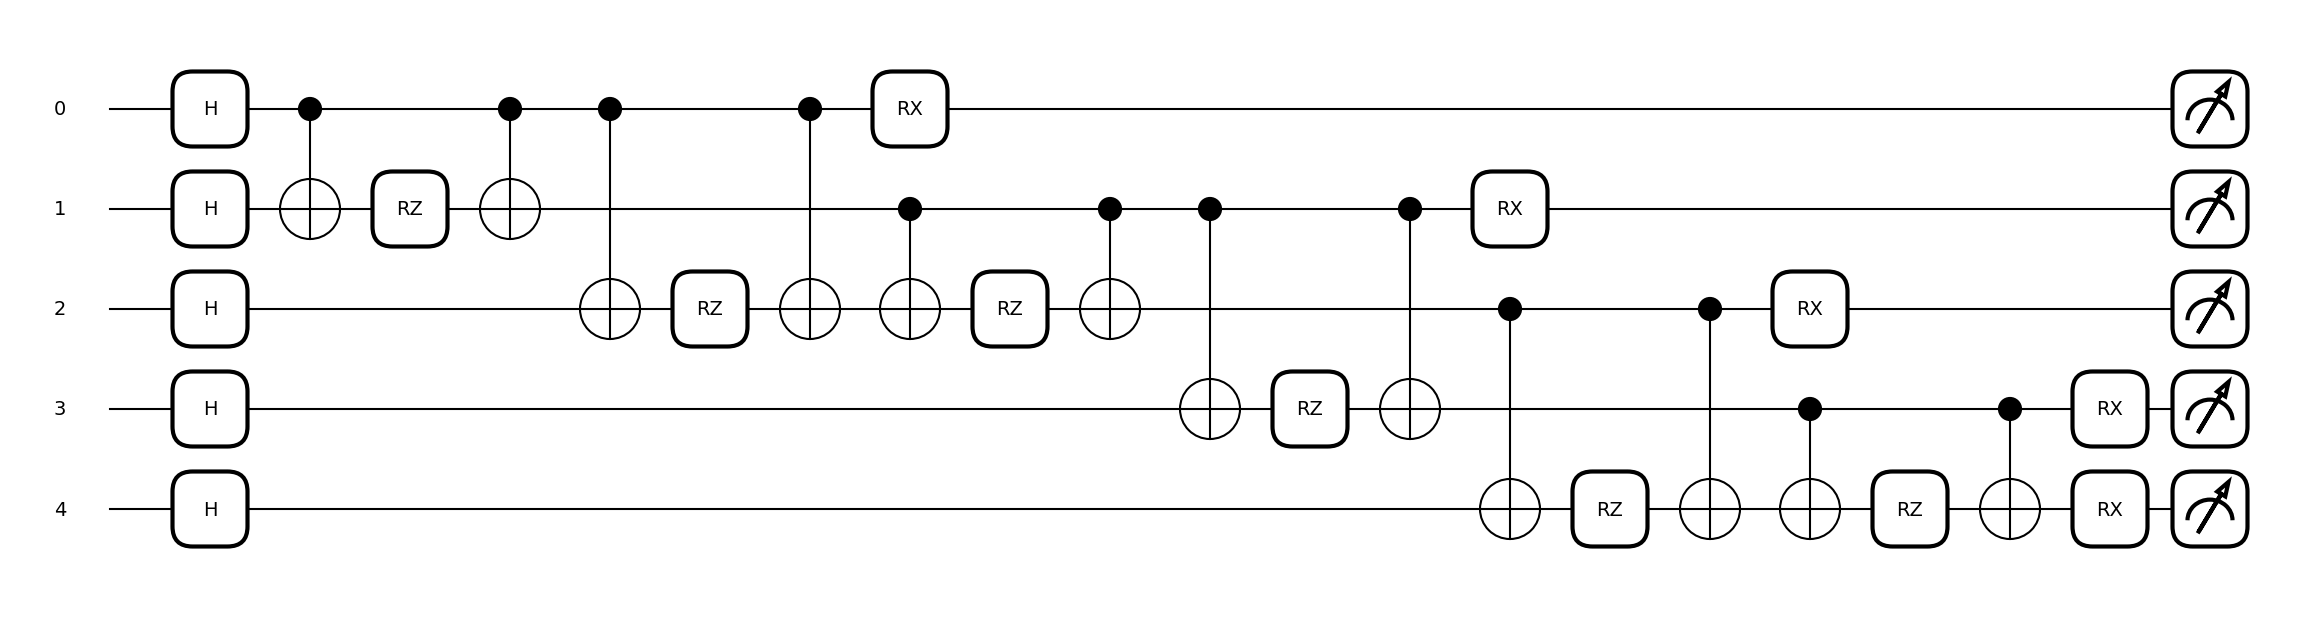

In [9]:
#QAOA Circuit Illustration
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Number of qubits for 5 regions
n_qubits = 5
depth_p = 1

# Example connections (edges in QUBO graph): fully connected or based on correlation matrix
edges = [(0,1), (0,2), (1,2), (1,3), (2,4), (3,4)]

# Initialize a PennyLane device
dev = qml.device("default.qubit", wires=n_qubits)

# Define QAOA ansatz for CVaR QUBO
@qml.qnode(dev)
def qaoa_circuit(gamma, beta):
    # Initial state: |+> for all qubits
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Cost Layer: ZZ interactions (based on edges)
    for (i, j), gamma_val in zip(edges, gamma):
        qml.CNOT(wires=[i, j])
        qml.RZ(2 * gamma_val, wires=j)
        qml.CNOT(wires=[i, j])

    # Mixer Layer: RX(beta) on each qubit
    for i, beta_val in enumerate(beta):
        qml.RX(2 * beta_val, wires=i)

    return qml.state()

# Sample gamma and beta values for visualization
gamma_sample = np.array([0.1]*len(edges))
beta_sample = np.array([0.2]*n_qubits)

# Draw the circuit
fig, ax = qml.drawer.draw_mpl(qaoa_circuit)(gamma_sample, beta_sample)
fig.savefig("/kaggle/working/circ.png", dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, execute
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA

# Step 1: Define QUBO matrix based on risk and correlation
def define_qubo_matrix(risks, correlations, alpha=1.0, beta=0.5):
    """
    risks: list or np.array of individual region risks
    correlations: 2D array of pairwise correlations between regions
    alpha: risk weight factor
    beta: correlation weight factor
    """
    n = len(risks)
    Q = np.zeros((n, n))
    for i in range(n):
        Q[i, i] = alpha * risks[i]
        for j in range(i + 1, n):
            Q[i, j] = beta * correlations[i, j]
    return Q

# Step 2: Convert QUBO matrix into a QuadraticProgram
def build_quadratic_program(Q):
    n = Q.shape[0]
    qp = QuadraticProgram()
    for i in range(n):
        qp.binary_var(name=f"x{i}")
    for i in range(n):
        qp.objective.set_linear(i, Q[i, i])
        for j in range(i + 1, n):
            qp.objective.set_quadratic(i, j, Q[i, j])
    qp.minimize()
    return qp

# Step 3: Solve QUBO with QAOA using gate-based simulator
def solve_qubo_qaoa(Q, p=1, shots=1024):
    qp = build_quadratic_program(Q)

    backend = Aer.get_backend("qasm_simulator")
    quantum_instance = QuantumInstance(backend, shots=shots)

    qaoa = QAOA(optimizer=COBYLA(), reps=p, quantum_instance=quantum_instance)
    optimizer = MinimumEigenOptimizer(qaoa)
    result = optimizer.solve(qp)

    print("\n✅ QAOA Solution:")
    print("Optimal value:", result.fval)
    print("Selection:", result.x)

    return result.x, result.fval

# Step 4: Visualize portfolio selection as binary bar chart
def visualize_portfolio_weights(selection, region_labels=None):
    n = len(selection)
    labels = region_labels if region_labels else [f"Region {i}" for i in range(n)]

    plt.figure(figsize=(10, 4))
    plt.bar(labels, selection, color="teal")
    plt.xticks(rotation=45, ha='right')
    plt.title("Optimized Risk Diversification via QAOA")
    plt.ylabel("Selected (1) or Not (0)")
    plt.tight_layout()
    plt.show()

# Example usage with synthetic data
def run_demo():
    regions = ['North', 'South', 'East', 'West', 'Central']
    risks = np.array([0.3, 0.6, 0.5, 0.7, 0.4])  # Lower is better
    correlations = np.array([
        [1.0, 0.6, 0.3, 0.2, 0.5],
        [0.6, 1.0, 0.4, 0.5, 0.3],
        [0.3, 0.4, 1.0, 0.6, 0.2],
        [0.2, 0.5, 0.6, 1.0, 0.4],
        [0.5, 0.3, 0.2, 0.4, 1.0],
    ])
    Q = define_qubo_matrix(risks, correlations)
    selection, _ = solve_qubo_qaoa(Q)
    visualize_portfolio_weights(selection, region_labels=regions)